<a href="https://colab.research.google.com/github/Elhai12/SBA_loans_predict/blob/main/EDA_Data_Cleansing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.6 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=fb26658ed87f3809f41a887638cdca411de67564b224aebaa2186972f805e165
  Stored in directory: /root/.cache/pip/wheels/1a/f3/a1/f7f10b5ae2c2459398762a3fcf4ac18c325311c7e3163d5a15
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=b6e3e79fb7078d41439da74f79704ce3e76ef88536974d38fed018137e09d8c0
  Stored in directory: /root/.cache/pip/wheels/ea/e8/e0/79872972161e54486517ae507f94b2c7cea27fb7ef793bd415
Successfully built fancyimpute knnimpute


In [2]:
!pip install missingno

In [3]:
#Clone git to get the files
!git clone https://github.com/Elhai12/SBA_loans_predict.git

Cloning into 'SBA_loans_predict'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 116 (delta 58), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 18.81 MiB | 5.58 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')

import time
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.subplots as sp
from scipy.stats import mannwhitneyu,chisquare,chi2_contingency
import plotly.express as px
from SBA_loans_predict import Functions_for_EDA
from scipy.stats import norm, ks_2samp
import missingno as msno
import fancyimpute
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

In [5]:
df = pd.read_pickle("/content/SBA_loans_predict/sba_loans_flat_pkl.pkl")

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApprovalFY,41212.0,2002.473915,4.985088,1971.000,1999.000,2004.000,2006.00,2014.000
Term,41212.0,110.743546,79.484949,0.000,60.000,84.000,120.00,360.000
NoEmp,41212.0,9.030452,23.316526,0.000,2.000,4.000,9.00,2100.000
CreateJob,41212.0,4.138406,130.405083,0.000,0.000,0.000,2.00,8800.000
RetainedJob,41212.0,6.163350,132.268420,0.000,0.000,1.000,4.00,8800.000
DisbursementGross,41212.0,206791.720834,307661.611129,0.000,35057.000,95442.500,243000.00,5000000.000
GrAppv,41212.0,198424.634767,309303.216333,2500.000,30000.000,75000.000,230000.00,5000000.000
SBA_Appv,41212.0,152805.400296,249756.329399,1500.000,17500.000,50000.000,180000.00,4500000.000
Month_apv,41212.0,6.541056,3.365058,1.000,4.000,7.000,9.00,12.000
Day_apv,41212.0,16.036616,8.724228,1.000,9.000,16.000,23.00,31.000


In [7]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()

#Outliers

##Outliers Detection

###Visual Detection

In [8]:
#Create grid of boxplot for eac numeric feature
fig = make_subplots(rows=4, cols=4, subplot_titles=num_cols)


for i, col in enumerate(num_cols):
    row, col_idx = divmod(i, 4)
    row += 1
    col_idx += 1

    box_fig = px.box(df, x=col, title=col)


    for trace in box_fig.data:
        fig.add_trace(trace, row=row, col=col_idx)
fig.show()

In [9]:
#Exploresion the specific outliers values
df[df['SBA_Appv']>=3500000]

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,Bank_State_group,Region,Is_Franchise,Category_bank,Sector_group,Month_apv,Day_apv,Diff_days,FEDFUNDS,change_rate_fed
18648,2009,240,40,2.0,23,40,1,N,N,4000000.0,...,FL,Central Florida,1,Other,"Culture, Leisure, and Restaurants",3,20,509.0,0.18,-0.182
22902,2011,300,15,1.0,0,0,1,N,N,4068000.0,...,GA,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",12,28,63.0,0.07,-0.125
24144,2011,12,32,1.0,0,32,1,Y,N,4000000.0,...,GA,South Florida,1,Commercial Bank,Construction and Infrastructure,9,8,23.0,0.08,-0.200
25180,2012,12,55,1.0,0,55,1,Y,N,4000000.0,...,IL,South Florida,1,Commercial Bank,Manufacturing,3,14,0.0,0.13,0.300
26801,2013,2,65,1.0,5,65,1,Y,N,5000000.0,...,GA,South Florida,1,Commercial Bank,Construction and Infrastructure,11,23,8.0,0.08,-0.111
27999,2013,120,0,1.0,0,0,1,N,N,5000000.0,...,GA,South Florida,1,Commercial Bank,Public Services and Health,2,11,18.0,0.15,0.071
28505,2013,12,27,1.0,5,27,1,Y,N,4000000.0,...,SD,South Florida,1,Other,Construction and Infrastructure,3,13,0.0,0.14,-0.067


In [10]:
df[df['Term']>=250]['MIS_Status'].value_counts()

,count
MIS_Status,
P I F,2945
CHGOFF,112


### Mathematical Detection

In [11]:
#I chose to identify outliers using the IQR method because, during the EDA, we observed that most of the features do not follow a normal distribution.

dict_outliers = {}
dict_range = {}
for col in num_cols:

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    dict_range[col] = [lower_limit, upper_limit]
    #Count number of rows that outliers
    num_outliers = df[(df[col] > upper_limit) | (df[col] < lower_limit)][col].count()
    #Count all rows
    all_obs = len(df[col])
    percent = round((num_outliers / all_obs)*100,2)

    dict_outliers[col] = [num_outliers, all_obs, percent]

df_outliers = pd.DataFrame.from_dict(dict_outliers, orient='index', columns=['num_outliers', 'all_obs', 'percent'])
df_outliers = df_outliers[df_outliers['percent']>0]
df_outliers

,num_outliers,all_obs,percent
ApprovalFY,241,41212,0.58
Term,7982,41212,19.37
NoEmp,4323,41212,10.49
CreateJob,4135,41212,10.03
RetainedJob,3756,41212,9.11
DisbursementGross,3991,41212,9.68
GrAppv,4228,41212,10.26
SBA_Appv,4315,41212,10.47
Diff_days,4296,41212,10.42
FEDFUNDS,46,41212,0.11


In [12]:
df_copy = df.copy()
df_copy['MIS_Status'] = df_copy['MIS_Status'].map({'P I F':1,'CHGOFF':0}).astype('category')

df_temp = df.copy()
df_temp['MIS_Status'] = df_temp['MIS_Status'].map({'P I F':1,'CHGOFF':0}).astype('category')
for col in df_outliers.index:
  #Get the upper and lower limit from dictionary of ranges was created above
    upper_limit = dict_range[col][1]
    lower_limit = dict_range[col][0]
    df_temp[col] = np.where(df_temp[col] > upper_limit,np.nan,np.where(df_temp[col] < lower_limit,np.nan,df_temp[col]))

df_temp

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,Bank_State_group,Region,Is_Franchise,Category_bank,Sector_group,Month_apv,Day_apv,Diff_days,FEDFUNDS,change_rate_fed
0,1997.0,NaN,14.0,1.0,NaN,7.0,0,N,N,229000.0,...,FL,East Florida,1,Other,NaN,2,28,75.0,5.19,-0.011
1,1997.0,84.0,1.0,2.0,0.0,0.0,0,N,Y,45000.0,...,other,South Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",2,28,NaN,5.19,-0.011
2,1997.0,NaN,2.0,2.0,0.0,0.0,0,N,N,305000.0,...,FL,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",2,28,153.0,5.19,-0.011
3,1997.0,87.0,2.0,1.0,0.0,0.0,0,N,N,70000.0,...,FL,South Florida,1,Other,Public Services and Health,2,28,184.0,5.19,-0.011
4,2006.0,84.0,4.0,1.0,0.0,4.0,1,Y,N,51440.0,...,FL,South Florida,1,Other,Construction and Infrastructure,2,7,21.0,4.49,0.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41207,1997.0,60.0,15.0,1.0,0.0,0.0,0,N,Y,95000.0,...,FL,Central Florida,1,Other,NaN,2,25,187.0,5.19,-0.011
41208,1997.0,84.0,2.0,2.0,0.0,0.0,0,N,Y,20000.0,...,FL,North Florida,1,Commercial Bank,NaN,2,25,34.0,5.19,-0.011
41209,1997.0,60.0,NaN,2.0,0.0,0.0,0,N,N,145000.0,...,other,South Florida,1,Commercial Bank,NaN,2,26,NaN,5.19,-0.011
41210,1997.0,NaN,NaN,1.0,0.0,0.0,0,0,N,NaN,...,SD,East Florida,1,Commercial Bank,Manufacturing,2,26,33.0,5.19,-0.011


##Check the impact

In [13]:
#Function to compare the corr between the two population and target feature.
#Use this function to compare between the corr before the change the outliers to drop and after.
def cocor(x_before,y_before, x_after,y_after):

   #Use 'spearman' method beacuase the distribution not normal
    xy_corr_before = x_before.corr(y_before, method='spearman')
    xy_corr_after = x_after.corr(y_after, method='spearman')
    n1 = len(x_before)
    n2 = len(x_after)
    z_corr_before = 0.5 * np.log((1 + xy_corr_before)/(1 - xy_corr_before))
    z_corr_after = 0.5 * np.log((1 + xy_corr_after)/(1 - xy_corr_after))
    if n2 is None:
        n2 = n1
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = z_corr_before - z_corr_after
    z = abs(diff / se_diff_r)
    p = (1 - norm.cdf(z)) * 2
    return z, p

In [14]:
list_indicate_change = []
for col in df_outliers.index:
  x_all_data = df_copy[col]
  y_all_data = df_copy['MIS_Status']
  x_non_outliers = df_temp[col]
  y_non_outliers = df_temp['MIS_Status']
  p, pval = cocor(x_all_data,y_all_data,x_non_outliers,y_non_outliers)

  cor_change = np.where(pval < 0.05, '+', '-')
  # Outliers count and percent
  cnt_outliers = df_outliers.loc[col,'num_outliers']
  prc_outliers = df_outliers.loc[col,'percent']

  num_otliers = str(cnt_outliers) + ' (' + str(prc_outliers) + '%)'

  # KS test p-value for check change in distribution
  pval = ks_2samp(x_all_data, x_non_outliers)[1]
  dist_change = np.where(pval < 0.05, '+', '-')

  # Append the data as a dictionary
  list_indicate_change.append({
      'feature': col,
      'outliers_cnt': num_otliers,
      'distribution_changed': dist_change,
      'correlation_changed': cor_change

  })

df_indicate = pd.DataFrame(list_indicate_change)
df_indicate['drop'] = np.where((df_indicate['distribution_changed']=='+') & (df_indicate['correlation_changed']=='+'),'no','yes')
df_indicate

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,ApprovalFY,241 (0.58%),-,+,yes
1,Term,7982 (19.37%),-,+,yes
2,NoEmp,4323 (10.49%),-,+,yes
3,CreateJob,4135 (10.03%),-,+,yes
4,RetainedJob,3756 (9.11%),-,+,yes
5,DisbursementGross,3991 (9.68%),-,+,yes
6,GrAppv,4228 (10.26%),-,+,yes
7,SBA_Appv,4315 (10.47%),-,+,yes
8,Diff_days,4296 (10.42%),-,+,yes
9,FEDFUNDS,46 (0.11%),-,-,yes


##Treatment of the outliers

In [15]:
features_change_outliers = df_indicate[df_indicate['drop']=='yes']['feature'].tolist()
features_change_outliers

['ApprovalFY',
 'Term',
 'NoEmp',
 'CreateJob',
 'RetainedJob',
 'DisbursementGross',
 'GrAppv',
 'SBA_Appv',
 'Diff_days',
 'FEDFUNDS',
 'change_rate_fed']

In [16]:
df_manipulated = df_copy.copy()
#Change the outliers to Nan
for col in features_change_outliers:
  upper_limit = dict_range[col][1]
  lower_limit = dict_range[col][0]
  df_manipulated[col] = np.where(df_manipulated[col] > upper_limit,np.nan,np.where(df_manipulated[col] < lower_limit,np.nan,df_manipulated[col]))



In [17]:
df_manipulated.to_pickle("manipulated_data.pkl")

#Missing Values

In [18]:
#Convert to missing not valid values
df_manipulated_miss = df_manipulated.copy()
df_manipulated_miss['NewExist'] = df_manipulated_miss['NewExist'].apply(lambda x: x if x in [1,0] else np.nan)
for col in ['LowDoc','RevLineCr']:
  df_manipulated_miss[col] = df_manipulated_miss[col].apply(lambda x: x if x in ['Y','N'] else np.nan)

##Detection

<Axes: >

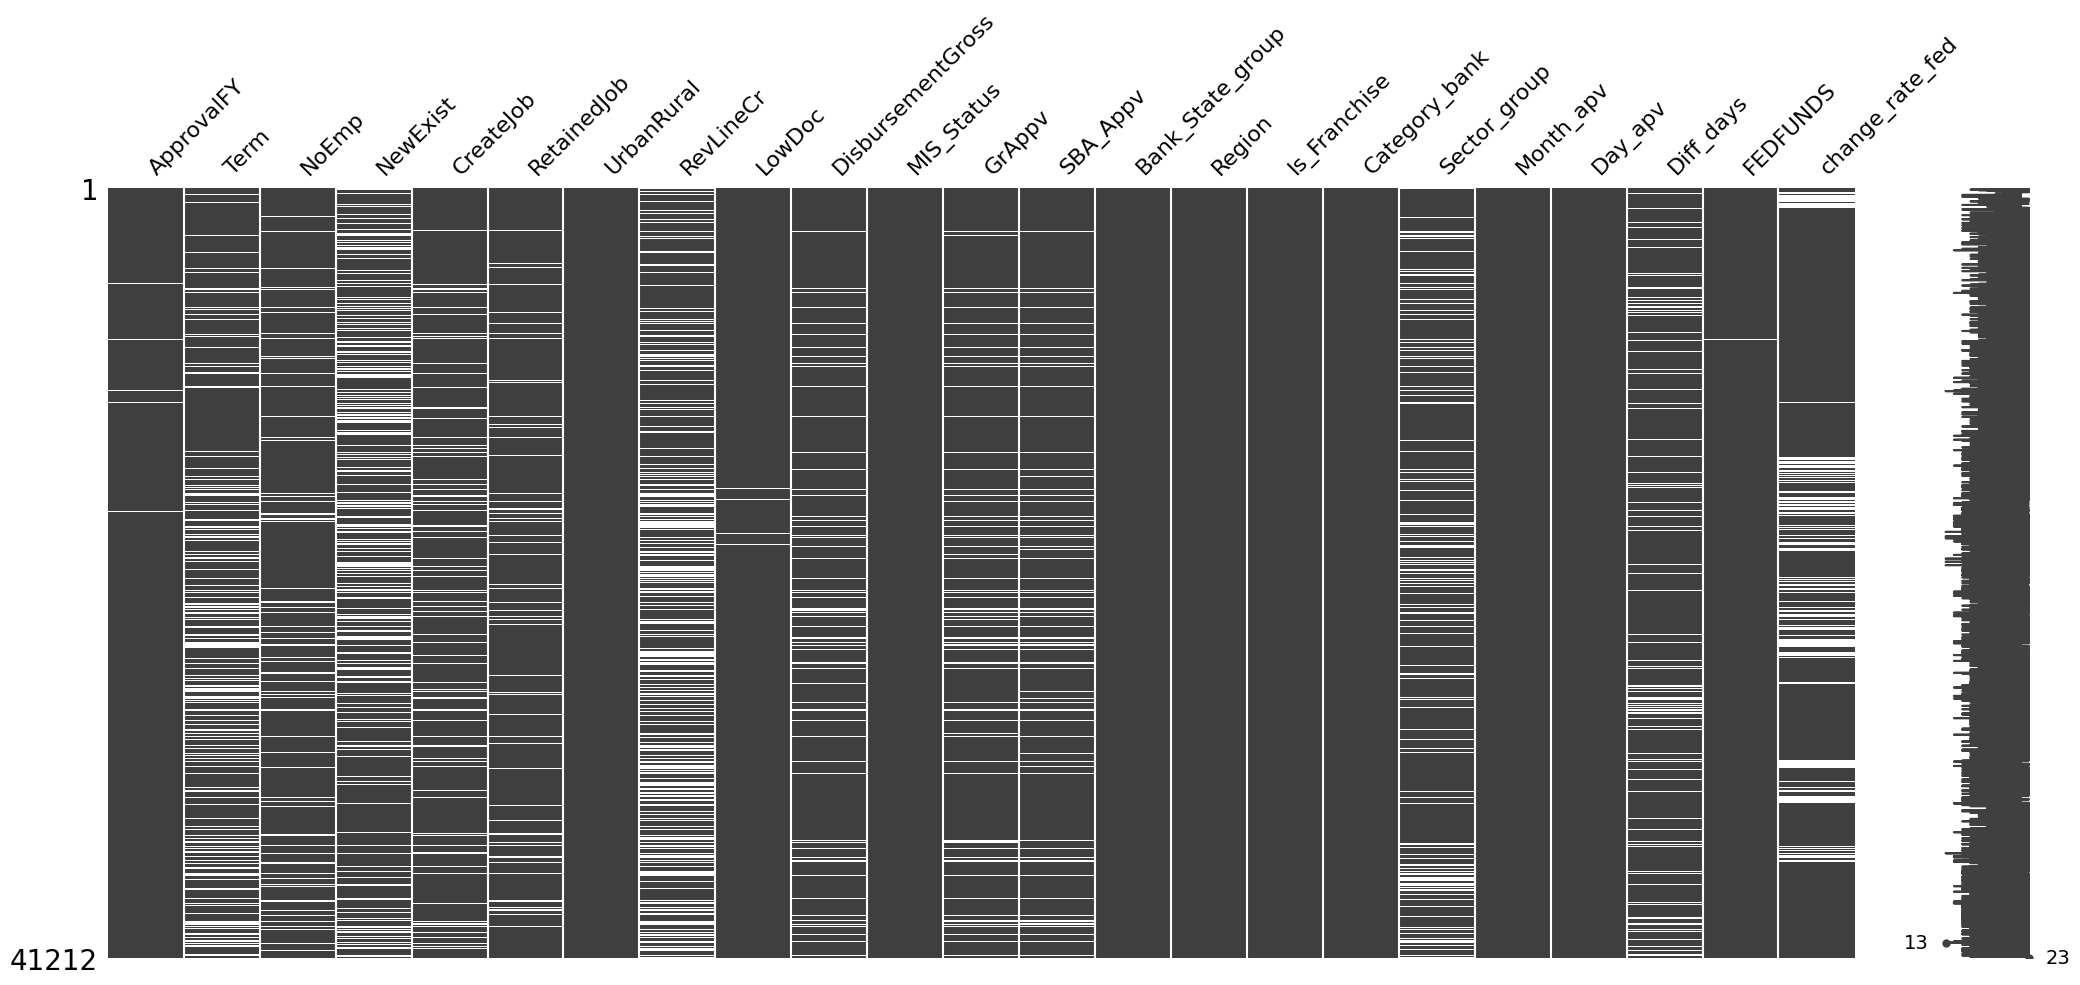

In [21]:
msno.matrix(df_manipulated_miss)

<Axes: >

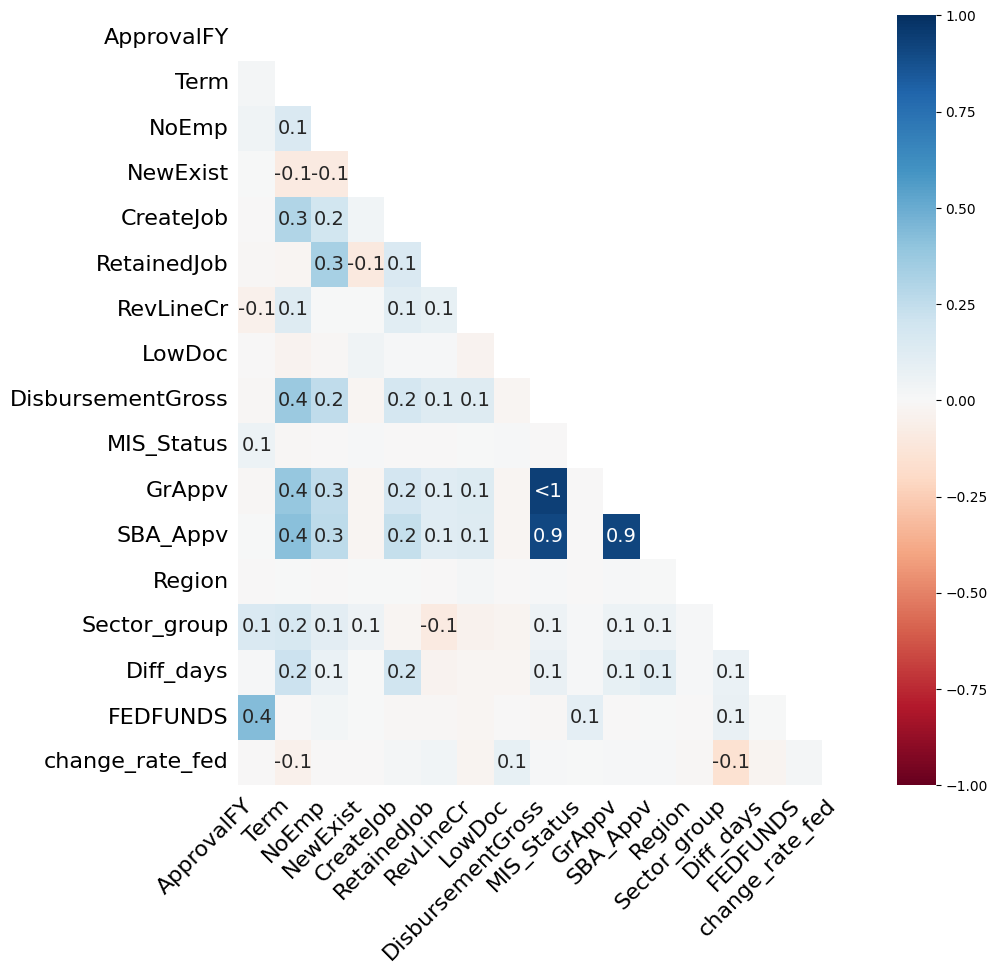

In [22]:
cols_missing = df_manipulated_miss.columns[df_manipulated_miss.isnull().any()].tolist()
msno.heatmap(df_manipulated_miss[cols_missing], figsize=(10,10))

In [23]:
df_null = pd.DataFrame(df_manipulated_miss.isna().sum(), columns=['cnt_null'])
df_null['percent'] = round((df_null['cnt_null']/len(df_manipulated_miss))*100,2)
df_null = df_null[df_null['cnt_null']>0].sort_values(by='percent', ascending=False)
df_null


,cnt_null,percent
RevLineCr,12933,31.38
NewExist,11226,27.24
Term,7982,19.37
Sector_group,6616,16.05
change_rate_fed,5918,14.36
Diff_days,4448,10.79
NoEmp,4323,10.49
SBA_Appv,4315,10.47
GrAppv,4228,10.26
CreateJob,4135,10.03


##Fill missings

In [38]:
#Use MICE for numarical features and KNN for category features
num_cols = df_manipulated_miss.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_manipulated_miss.select_dtypes(exclude=np.number).columns.tolist()

df_codes = df_manipulated_miss.copy()

#For imputer - change the strings columns to decodes (without MIS_Status that changed alardy)
#And save the codes and category for reverse after to orignal values
mappings = {}

for col in [c for c in cat_cols if c != 'MIS_Status']:

    df_codes[col] = df_codes[col].astype('category')
    mappings[col] = dict(enumerate(df_codes[col].cat.categories))
    df_codes[col] = df_codes[col].cat.codes.replace(-1, np.nan)




In [39]:
mappings['Region']

{0: 'Central Florida',
 1: 'East Florida',
 2: 'North Florida',
 3: 'South Florida',
 4: 'West Florida'}

In [40]:
X= df_codes.copy()


#Fit the KNN on all data
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
#Get only the category columns that fill
X_imputed_cat = pd.DataFrame(X_imputed,columns=X.columns)
X_imputed_cat = X_imputed_cat[cat_cols+['NewExist']].round().astype(int)

X_imputed_cat

,UrbanRural,RevLineCr,LowDoc,MIS_Status,Bank_State_group,Region,Is_Franchise,Category_bank,Sector_group,NewExist
0,0,0,0,1,1,1,0,5,4,1
1,0,0,1,1,9,3,0,1,2,1
2,0,0,0,1,1,0,0,1,2,1
3,0,0,0,1,1,3,0,5,8,1
4,1,1,0,1,1,3,0,5,1,1
...,...,...,...,...,...,...,...,...,...,...
41207,0,0,1,1,1,0,0,5,2,1
41208,0,0,1,1,1,2,0,1,4,1
41209,0,0,0,1,9,3,0,1,3,1
41210,0,0,0,1,6,1,0,1,5,1


In [44]:
#Check if have Null's after the KNN imputer
X_imputed_cat.isna().sum()

,0
UrbanRural,0
RevLineCr,0
LowDoc,0
MIS_Status,0
Bank_State_group,0
Region,0
Is_Franchise,0
Category_bank,0
Sector_group,0
NewExist,0


In [46]:
#Check if add additonal category and if the dist very change
print("New DataFrame")
print(X_imputed_cat.describe().T)
print("****"*30)
print("Original DataFrame")
print(df_codes[cat_cols+['NewExist']].describe().T)

New DataFrame
                    count      mean       std  min  25%  50%  75%  max
UrbanRural        41212.0  0.863996  0.584736  0.0  1.0  1.0  1.0  2.0
RevLineCr         41212.0  0.314714  0.464408  0.0  0.0  0.0  1.0  1.0
LowDoc            41212.0  0.094099  0.291970  0.0  0.0  0.0  0.0  1.0
MIS_Status        41212.0  0.726439  0.445792  0.0  0.0  1.0  1.0  1.0
Bank_State_group  41212.0  3.683296  2.773163  0.0  1.0  4.0  5.0  9.0
Region            41212.0  2.319470  1.222835  0.0  2.0  3.0  3.0  4.0
Is_Franchise      41212.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Category_bank     41212.0  1.947442  1.754165  0.0  1.0  1.0  3.0  5.0
Sector_group      41212.0  3.875522  2.759053  0.0  1.0  3.0  7.0  9.0
NewExist          41212.0  0.999660  0.018428  0.0  1.0  1.0  1.0  1.0
************************************************************************************************************************
Original DataFrame
                    count      mean       std  min  25%  50%  75%

In [47]:
#Check specific exemple
df_codes[df_codes['Region'].isna()]

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,Bank_State_group,Region,Is_Franchise,Category_bank,Sector_group,Month_apv,Day_apv,Diff_days,FEDFUNDS,change_rate_fed
826,2006.0,NaN,2.0,1.0,4.0,0.0,2,NaN,0.0,308000.0,...,1,NaN,0,5,1.0,2,17,NaN,4.49,0.047
2270,1997.0,NaN,15.0,NaN,0.0,0.0,0,NaN,0.0,NaN,...,0,NaN,0,5,NaN,4,30,214.0,5.51,0.022
4933,1997.0,NaN,2.0,NaN,0.0,0.0,0,NaN,0.0,NaN,...,7,NaN,0,5,NaN,9,3,58.0,5.54,0.000
5641,1998.0,NaN,3.0,1.0,0.0,0.0,0,NaN,0.0,280000.0,...,1,NaN,0,1,NaN,10,10,82.0,5.07,-0.080
6601,1998.0,29.0,4.0,NaN,0.0,0.0,0,0.0,1.0,35000.0,...,1,NaN,0,1,NaN,12,11,51.0,4.68,-0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40316,1996.0,13.0,7.0,1.0,0.0,0.0,0,1.0,0.0,15000.0,...,6,NaN,0,1,1.0,8,16,NaN,5.22,-0.033
40544,1996.0,9.0,8.0,1.0,0.0,0.0,0,1.0,0.0,18577.0,...,6,NaN,0,1,2.0,9,27,126.0,5.30,0.015
41002,1997.0,NaN,2.0,1.0,0.0,0.0,0,0.0,1.0,65000.0,...,9,NaN,0,1,2.0,12,20,NaN,5.50,-0.004
41074,2006.0,NaN,NaN,1.0,NaN,0.0,2,NaN,0.0,NaN,...,1,NaN,0,5,5.0,2,6,191.0,4.49,0.047


In [48]:
X_imputed_cat.loc[2270]

,2270
UrbanRural,0
RevLineCr,0
LowDoc,0
MIS_Status,0
Bank_State_group,0
Region,3
Is_Franchise,0
Category_bank,5
Sector_group,3
NewExist,1


In [49]:
#Reverse to category values for will treat in feature engineering stage (without MIS_Status)
X_revers_cat = X_imputed_cat.copy()
for col in [c for c in cat_cols if c != 'MIS_Status']:
  X_revers_cat[col] = X_revers_cat[col].astype(int)
  X_revers_cat[col] = X_revers_cat[col].map(mappings[col]).astype('category')
X_revers_cat

,UrbanRural,RevLineCr,LowDoc,MIS_Status,Bank_State_group,Region,Is_Franchise,Category_bank,Sector_group,NewExist
0,0,N,N,1,FL,East Florida,1,Other,Information and Communication,1
1,0,N,Y,1,other,South Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",1
2,0,N,N,1,FL,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",1
3,0,N,N,1,FL,South Florida,1,Other,Public Services and Health,1
4,1,Y,N,1,FL,South Florida,1,Other,Construction and Infrastructure,1
...,...,...,...,...,...,...,...,...,...,...
41207,0,N,Y,1,FL,Central Florida,1,Other,"Culture, Leisure, and Restaurants",1
41208,0,N,Y,1,FL,North Florida,1,Commercial Bank,Information and Communication,1
41209,0,N,N,1,other,South Florida,1,Commercial Bank,Finance and Insurance,1
41210,0,N,N,1,SD,East Florida,1,Commercial Bank,Manufacturing,1


In [50]:
#Check the reverse
df_manipulated_miss[cat_cols].loc[0:4]

,UrbanRural,RevLineCr,LowDoc,MIS_Status,Bank_State_group,Region,Is_Franchise,Category_bank,Sector_group
0,0,N,N,1.0,FL,East Florida,1,Other,NaN
1,0,N,Y,1.0,other,South Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants"
2,0,N,N,1.0,FL,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants"
3,0,N,N,1.0,FL,South Florida,1,Other,Public Services and Health
4,1,Y,N,1.0,FL,South Florida,1,Other,Construction and Infrastructure


In [51]:
#Use MICE for numeric features

X_imputed_num = fancyimpute.IterativeImputer(max_iter=15).fit_transform(X)
X_imputed_num = pd.DataFrame(X_imputed,columns=X.columns)
X_imputed_num = X_imputed_num[num_cols]
X_imputed_num

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,Month_apv,Day_apv,Diff_days,FEDFUNDS,change_rate_fed
0,1997.0,122.2,14.0,1.0,1.0,7.0,229000.0,229000.0,229000.0,2.0,28.0,75.0,5.19,-0.011
1,1997.0,84.0,1.0,1.0,0.0,0.0,45000.0,45000.0,36000.0,2.0,28.0,74.4,5.19,-0.011
2,1997.0,76.8,2.0,1.0,0.0,0.0,305000.0,305000.0,228750.0,2.0,28.0,153.0,5.19,-0.011
3,1997.0,87.0,2.0,1.0,0.0,0.0,70000.0,70000.0,56000.0,2.0,28.0,184.0,5.19,-0.011
4,2006.0,84.0,4.0,1.0,0.0,4.0,51440.0,35000.0,17500.0,2.0,7.0,21.0,4.49,0.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41207,1997.0,60.0,15.0,1.0,0.0,0.0,95000.0,95000.0,76000.0,2.0,25.0,187.0,5.19,-0.011
41208,1997.0,84.0,2.0,1.0,0.0,0.0,20000.0,20000.0,16000.0,2.0,25.0,34.0,5.19,-0.011
41209,1997.0,60.0,6.6,1.0,0.0,0.0,145000.0,145000.0,108750.0,2.0,26.0,120.2,5.19,-0.011
41210,1997.0,88.8,6.2,1.0,0.0,0.0,125400.0,198000.0,171981.6,2.0,26.0,33.0,5.19,-0.011


In [52]:
#Check if have Null's after the MICE
X_imputed_num.isna().sum()

,0
ApprovalFY,0
Term,0
NoEmp,0
NewExist,0
CreateJob,0
RetainedJob,0
DisbursementGross,0
GrAppv,0
SBA_Appv,0
Month_apv,0


In [53]:
#Check if not add additonal category and if the dist very change
print("New DataFrame")
print(X_imputed_num.describe().T)
print("****"*30)
print("Original DataFrame")
print(df_codes[num_cols].describe().T)

New DataFrame
                     count           mean            std       min        25%  \
ApprovalFY         41212.0    2002.550616       4.798512  1989.000   1999.000   
Term               41212.0      80.327269      34.635317     0.000     60.000   
NoEmp              41212.0       5.220732       4.079136     0.000      2.000   
NewExist           41212.0       0.999190       0.020814     0.000      1.000   
CreateJob          41212.0       0.686222       1.226456     0.000      0.000   
RetainedJob        41212.0       1.888785       2.520844     0.000      0.000   
DisbursementGross  41212.0  136587.058813  130041.667954     0.000  35000.000   
GrAppv             41212.0  126742.128598  128571.906635  2500.000  30000.000   
SBA_Appv           41212.0   95631.061429  105054.809004  1500.000  17500.000   
Month_apv          41212.0       6.541056       3.365058     1.000      4.000   
Day_apv            41212.0      16.036616       8.724228     1.000      9.000   
Diff_days     

In [54]:
#Union the number features df was fill by MICE with Categoty features df
df_final_fill_missing = pd.concat([X_imputed_num, X_revers_cat], axis=1)
df_final_fill_missing

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,Month_apv,...,UrbanRural,RevLineCr,LowDoc,MIS_Status,Bank_State_group,Region,Is_Franchise,Category_bank,Sector_group,NewExist
0,1997.0,122.2,14.0,1.0,1.0,7.0,229000.0,229000.0,229000.0,2.0,...,0,N,N,1,FL,East Florida,1,Other,Information and Communication,1
1,1997.0,84.0,1.0,1.0,0.0,0.0,45000.0,45000.0,36000.0,2.0,...,0,N,Y,1,other,South Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",1
2,1997.0,76.8,2.0,1.0,0.0,0.0,305000.0,305000.0,228750.0,2.0,...,0,N,N,1,FL,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",1
3,1997.0,87.0,2.0,1.0,0.0,0.0,70000.0,70000.0,56000.0,2.0,...,0,N,N,1,FL,South Florida,1,Other,Public Services and Health,1
4,2006.0,84.0,4.0,1.0,0.0,4.0,51440.0,35000.0,17500.0,2.0,...,1,Y,N,1,FL,South Florida,1,Other,Construction and Infrastructure,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41207,1997.0,60.0,15.0,1.0,0.0,0.0,95000.0,95000.0,76000.0,2.0,...,0,N,Y,1,FL,Central Florida,1,Other,"Culture, Leisure, and Restaurants",1
41208,1997.0,84.0,2.0,1.0,0.0,0.0,20000.0,20000.0,16000.0,2.0,...,0,N,Y,1,FL,North Florida,1,Commercial Bank,Information and Communication,1
41209,1997.0,60.0,6.6,1.0,0.0,0.0,145000.0,145000.0,108750.0,2.0,...,0,N,N,1,other,South Florida,1,Commercial Bank,Finance and Insurance,1
41210,1997.0,88.8,6.2,1.0,0.0,0.0,125400.0,198000.0,171981.6,2.0,...,0,N,N,1,SD,East Florida,1,Commercial Bank,Manufacturing,1


In [55]:
df_final_fill_missing.to_pickle("manipulated_data.pkl")